# Low-Level API

## Prerequisites

If you've already completed the instructions on the **Installation** page, then let's get started.

In [2]:
import aiqc
from aiqc import datum

## 1. Ingest a `Dataset`

### Object Relational Model (ORM)

![Datasets](../images/dimensionality.png)

The `Dataset` class provides the following subclasses for working with different dimensionalities of data:

- `Dataset.Tabular` - 2D constructed from either an array/dataframe or a tabular file.
- `Dataset.Sequence` - 3D constructed from an array.
- `Dataset.Image` - 4D constructed from either an array, a folder of files, or a list of URLs.

During each stage of both the preprocessing and postprocessing pipelines, these shapes of data need to be handled differently. Additionally, each split and/or fold needs to be processed separately in order to avoid data leakage. You may also find yourself combining heterogenous featuresets (e.g. both tabular data and image data). All of these transformations needs to be recorded. The reason for this is that when making predictions during inference, the new samples must be processed identically to the original samples that the model was trained upon. Then these predictions must be decoded into their natural forms. AIQC coordinates all of this.

### Registering Datasets

The `ingest:bool=True` parameter dictates whether or not the data is ingested into SQLite or if remains on disk and is accessed via `source_path`.

By default the actual bytes of the file are persisted to the SQLite `BlobField`. It gets gzip compressed, reducing the size by up to 90%. Maximum BlobField size is 2.147 GB, but once you factor in compression, your bottleneck is more likely to be memory beyond that size. The bytes themselves are Parquet (single-partitioned) because, using the PyArrow engine, it preserves every dtype except certain datetimes (which are honestly better off parsed into floats/ ordinal ints). Parquet is also integrated nicely into both Spark and Dask; frameworks for distributed, in-memory computation.

Persisting the file ensures reproducibility by: (a) keeping the data packaged alongside the experiment, and (b) helping entry-level users move away from relying on mutable dataframes they have had in-memory for extended periods of time or floating around on shared file systems.

> *However, we realize that a different approach will be required at scale, so the `source_path` of the file is recorded whenever possible. In the future we could just read the data from that path (e.g. NFS, RDBMS, HDFS, S3) if the BlobField is none. Or just switch our data fetching/ filtering to Dask because it uses the Pandas API and Parquet.*

#### `Dataset.Tabular`

##### `from_pandas()`

In [4]:
df = datum.to_pandas('iris.tsv')

dataset = aiqc.Dataset.Tabular.from_pandas(
	dataframe = df
    , name = 'tab separated plants'
    , dtype = None #passed to pd.Dataframe(dtype)/ inferred
    , column_names = None #passed to pd.Dataframe(columns)
)

> Optionally, `dtype`, as seen in the `pandas.DataFrame.astype(dtype)` [docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html), can be specified as either a single type for all columns, or as a dictionary that maps a specific type to each column name. This encodes features for analysis. We read NumPy into Pandas before persisting it, so `columns` and `dtype` are read directly by `pd.DataFrame()`.

##### `from_numpy()`

Must be a 2D NumPy N-Dimensional Array.

> *In the future, we may add support for ingesting 3D arrays as multi-file sequences.*

Regular *ndarrays* don't have column names, and I didn't like the API for *structured arrays* so you have to pass in columns names as a list. If you don't then column names will be numerically assigned in ascending order (zero-based index), but I didn't like the range object, so I stringified numerically assigned columns to string-based numbers.

In [5]:
arr =  df.to_numpy()
cols = list(df.columns)

other_dataset = aiqc.Dataset.Tabular.from_numpy(
	ndarray = arr
    , column_names = cols #passed to pd.Dataframe(columns)
)

##### `from_path()`

Intended for flat files, delimited text, and structured tabular data. It's read in via Pandas, so it supports URLs to raw data and bytes as well.

The `file_path` itself can be either absolute or relative.

In [6]:
file_path = datum.get_path('iris_10x.tsv')

# We'll keep this larger dataset handy for `Foldset` creation later.
big_dataset = aiqc.Dataset.Tabular.from_path(
    file_path = file_path
    , source_file_format = 'tsv'
    , name = None
    , dtype = None
    , column_names = None
    , skip_header_rows = 'infer' #passed to `pd.read_csv(header)`. Incompatible w Parquet.
)

> If you leave `name` blank, it will default to a human-readble timestamp with the appropriate file extension (e.g. '2020_10_13-01_28_13_PM.tsv').

#### `Dataset.Sequence`

The sequence dataset is a 3 dimensional structure intended for multi-observations per sample to enable time series analysis. 

Observations must be ordered in an *ascending* manner, which means:

- Time-based data must be ordered from earlier to later (2010 - 2020).
- Position-based data must be ordered from beginning to end (start - stop).

Sequence datasets are somewhat multi-modal in that, in order to perform supervised learning on them, they require a loosely coupled `Dataset.Tabular` that contains their labels.

In [14]:
df = datum.to_pandas('epilepsy.parquet')

The `['seizure']` column of this dataframe serves as the Label of that sample. We'll construct a `Dataset.Tabular` from this.

In [15]:
label_df = df[['seizure']]

In [16]:
dataset_tabular = aiqc.Dataset.Tabular.from_pandas(label_df)

In [17]:
tabular_label = dataset_tabular.make_label(columns='seizure')

##### `from_numpy()`

`from_numpy(ndarray_3D:object)` requires a 3D NumPy array where each 2D array represents a sample. So we'll drop our seizure column from our DataFrame and reshape it into a 3D array.

In [18]:
seq_ndarray3D = df.drop(columns=['seizure']).to_numpy().reshape(1000,178,1)

In [19]:
dataset_sequence = aiqc.Dataset.Sequence.from_numpy(
    ndarray_3D = seq_ndarray3D
    , column_names = ['EEG']
)

⏱️ Ingesting Sequences 🧬: 100%|████████████████| 1000/1000 [00:09<00:00, 105.99it/s]


In [20]:
sequence_feature = dataset_sequence.make_feature()

Skipping forward a bit, we bring the heterogenous `Feature` and `Label` together in the `Splitset`.

In [21]:
sequence_splitset = aiqc.Splitset.make(
    feature_ids = [sequence_feature.id]
    , label_id = tabular_label.id
    , size_test = 0.24
    , size_validation = 0.12
)

> It is also possible to create a `Foldset` from this splitset.

#### `Dataset.Image`

Image datasets are somewhat multi-modal in that, in order to perform supervised learning on them, they require a loosely coupled `Dataset.Tabular` that contains their labels.

In [3]:
df = datum.to_pandas(name='brain_tumor.csv')
df.head()

,status,size,count,symmetry,url
0,0,0,0,NaN,https://raw.githubusercontent.com/aiqc/aiqc/ma...
1,0,0,0,NaN,https://raw.githubusercontent.com/aiqc/aiqc/ma...
2,0,0,0,NaN,https://raw.githubusercontent.com/aiqc/aiqc/ma...
3,0,0,0,NaN,https://raw.githubusercontent.com/aiqc/aiqc/ma...
4,0,0,0,NaN,https://raw.githubusercontent.com/aiqc/aiqc/ma...


The `['status']` column of this dataframe serves as the Label of that sample. We'll construct a `Dataset.Tabular` from this.

In [4]:
tabular_dataset = aiqc.Dataset.Tabular.from_pandas(dataframe=df)

In [5]:
tabular_label = tabular_dataset.make_label(columns=['status'])

##### `from_urls_pillow()`

During ingestion, all image files must have the same `Image.mode` and `Image.size` according to the Pillow library.

> https://pillow.readthedocs.io/en/stable/handbook/concepts.html

`from_urls(urls:list)` needs a list of urls. In order to perform supervised learning, the order of this list must line up with the samples in your Tabular dataset.
> We happen to have this list prepared in the `['url']` column of the dataframe above.  acts as a manifest in that it contains the URL of the image file for that sample, solely for the purposes of initial ingestion. We'll construct a `Dataset.Image` from this.

In [6]:
image_urls = datum.get_remote_urls(manifest_name='brain_tumor.csv')

In [7]:
image_dataset = aiqc.Dataset.Image.from_urls_pillow(urls=image_urls)

🖼️ Ingesting Images 🖼️: 100%|████████████████████████| 80/80 [00:07<00:00, 10.36it/s]


In [12]:
image_feature = image_dataset.make_feature()

Skipping forward a bit, we bring the heterogenous `Feature` and `Label` together in the `Splitset`.

In [13]:
image_splitset = aiqc.Splitset.make(
    feature_ids = [image_feature.id]
    , label_id = tabular_label.id
    , size_test = 0.24
    , size_validation = 0.12
)

> It is also possible to create a `Foldset` from this splitset.

##### `from_folder_pillow()`

When reading images from a locally accessible folder, the fantastic `natsort.natsorted` library is used as the source of truth for the order of the files.
> Python reads files by insertion order rather than alpha-numerically, which isn't intuitive for humans. So make sure your tabular manifest has the same order as `natsorted`. https://natsort.readthedocs.io/en/master/api.html#natsort.natsorted

In [14]:
image_dataset = aiqc.Dataset.Image.from_folder_pillow("/Users/layne/desktop/MRI_scans")

🖼️ Ingesting Images 🖼️: 100%|███████████████████████| 80/80 [00:00<00:00, 209.31it/s]


Here you can see the first 3 files that comprise that dataset.

In [15]:
image_dataset.files[:3]

[<File: 85>, <File: 86>, <File: 87>]

In [16]:
image_feature = image_dataset.make_feature()

In [17]:
image_splitset = aiqc.Splitset.make(
    feature_ids = [image_feature.id]
    , label_id = tabular_label.id
    , size_test = 0.24
    , size_validation = 0.12
)

##### `from_numpy()`

```python
Dataset.Image.from_numpy(
        ndarray4D_or_npyPath:object
        , name:str = None
        , dtype:object = None
        , column_names:list = None
        , ingest:bool = True
    )
```

### Reading Datasets into Memory

All of the sample-related objects in the API have `to_numpy()` and `to_pandas()` methods that accept the following arguments:

* `samples=[]` list of indices to fetch.
* `columns=[]` list of columns to fetch.
* In some cases you can specify a `split`/ `fold` name.

For structured data, since the `Dataset` itself is fairly removed from the `File.Tabular` it creates, you can get that tabular file with `Dataset.Tabular.get_main_tabular(dataset_id)` to inspect attributes like `dtypes` and `columns`.

Later, we'll see how these arguments allow downstream objects like `Splitset` and `Foldset` to slice up the data.

#### `Dataset.Tabular`

##### `to_pandas()`

In [18]:
df = dataset.to_pandas()
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [19]:
df = aiqc.Dataset.to_pandas(
    id = dataset.id 
    , samples = [0,13,29,79]
    , columns = ['sepal_length', 'sepal_width']
)
df.tail()

,sepal_length,sepal_width
0,5.1,3.5
13,4.3,3.0
29,4.7,3.2
79,5.7,2.6


##### `to_numpy()`

In [20]:
arr = dataset.to_numpy(
    samples = [0,13,29,79] 
    , columns = ['petal_length', 'petal_width']
)
arr[:4]

array([[1.4, 0.2],
       [1.1, 0.1],
       [1.6, 0.2],
       [3.5, 1. ]])

In [21]:
arr = aiqc.Dataset.to_numpy(id=dataset.id)
arr[:4]

array([[5.1, 3.5, 1.4, 0.2, 'setosa'],
       [4.9, 3.0, 1.4, 0.2, 'setosa'],
       [4.7, 3.2, 1.3, 0.2, 'setosa'],
       [4.6, 3.1, 1.5, 0.2, 'setosa']], dtype=object)

#### `Dataset.Sequence`

In [ ]:
arr = dataset.to_numpy(
    samples = [0] 
    , columns = None
)
arr[0][:5]

##### `to_numpy()`

This essentially internal method only exists to enable Pandas-related preprocessing such as interpolation. Produces a list of dataframes. 

##### `to_pandas()`

This essentially internal method only exists to enable Pandas-related preprocessing such as interpolation. Produces a list of dataframes. 

##### `to_pillow()`

This essentially internal method only exists to fetch images in their natural form (e.g. PNG/JPG).

#### `Dataset.Image`

##### `to_pillow()`

Returns a list of `PIL.Image`'s. You can actually see the image when you call them. 

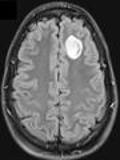

In [8]:
images_pillow = aiqc.Dataset.Image.to_pillow(id=image_dataset.id, samples=[60,61,62])
images_pillow[1]

##### `to_numpy()`

This simply performs `np.array(Pillow.Image)`. Returns an N-dimensional array where the dimensions vary based on the `mode` aka colorscale of the image. For example, it returns '3D of 2Ds for black and white' or '4D of 3Ds for colored' - which would change the class of convultional layer you would use (`Conv1D`:`Conv3D`).



> By default, the returned arrays will be scaled by 255 because [Pillow pixel values range from 0-255](https://pillow.readthedocs.io/en/stable/handbook/concepts.html#modes).

Let's check out one of the 2D color channels of a grayscale image.

In [14]:
images_pillow = aiqc.Dataset.Image.to_numpy(id=image_dataset.id, samples=[60,61,62])
images_pillow[1]

array([[0.04313725, 0.04313725, 0.04313725, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.01568627, 0.01568627, 0.01568627, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.        , 0.        , 0.        , ..., 0.07058824, 0.07058824,
        0.07058824],
       ...,
       [0.07058824, 0.07058824, 0.07058824, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.07058824, 0.07058824, 0.07058824, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.07058824, 0.07058824, 0.07058824, ..., 0.07058824, 0.07058824,
        0.07058824]])

## 2. Selecting `Features` and `Labels`.

### a) Select the `Label` column(s).

#### ORM

From a Dataset, pick the column(s) that you want to predict/ train against. Creating a `Label` won't duplicate your data! It simply marks the Dataset `columns` to be used for supervised learning. 

Later, we'll see that a `Label` triggers:

* The `supervision` attribute of a `Splitset` to be either `'unsupervised'`/`'supervised'`.

* Approval/ rejection of the `Algorithm.analysis_type`. For example, you wouldn't perform regression on a string label.

Part of the magic of this library is that it prevents you from making silly mistakes like these so that you aren't faced with some obscure NumPy/ Tensor, dtype/ dimensionality error on the nth layer of your neural network.

For categorical labels, but not for continuous/float labels, the `Label.unique_classes` are recorded.

#### Deriving Labels

Keep the name of the label column handy as you may want to re-use it later when excluding features.

In [24]:
label_column = 'species'

Implicit IDs

In [25]:
label = dataset.make_label(columns=[label_column])

> `columns=[label_column]` is a list in case users have already OneHotEncoded (OHEd) their label. If multiple columns are provided, then they must already be in OHE format. I'm not keen on supporting multi-label/ simultaneous analysis, but that could changed based on feasibility and user demand.

Explicit IDs

In [26]:
other_label = aiqc.Label.from_dataset(
	dataset_id=other_dataset.id
	, columns=[label_column]
)

#### Reading Labels

The `Label` comes in handy when we need to fetch what is traditionally referred to as '*Y*' in tutorials. It also accepts a `samples` argument, so that `Splitset` can subset it.

In [27]:
label.to_pandas().tail()

,species
145,virginica
146,virginica
147,virginica
148,virginica
149,virginica


In [28]:
label.to_numpy(samples=[0,33,66,99,132])[:5]

array([['setosa'],
       ['setosa'],
       ['versicolor'],
       ['versicolor'],
       ['virginica']], dtype=object)

### b) Select the `Feature` column(s).

#### ORM

Creating a Feature won't duplicate your data! It simply records the Dataset `columns` to be used as features during training. 

There are three ways to define which columns you want to use as features:

- `exclude_columns=[]` for ruling out columns like the `Label` column.
- `include_columns=[]` for being selective.
- Leave both of the above blank and all columns will be used (e.g. images or unsupervised leanring).

For structured data, since the Feature is far removed from the `File.Tabular` that it is derived from, there is a `Feature.get_dtypes()` method. This will come in handy when we are selecting dtypes/columns to include/ exclude in our `Featurecoder`(s).

#### Specifying Features

Via `include_columns=[]`

In [29]:
feature = dataset.make_feature(
    include_columns = [
        'sepal_length',
        'petal_length',
        'petal_width'
    ]
)

Or via `exclude_columns=[]`

In [30]:
feature = dataset.make_feature(exclude_columns=[label_column])

In [31]:
feature.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

Either way, any excluded columns will be recorded since they are used for dropping.

In [32]:
feature.columns_excluded

['species']

Again, for images, just perform `Dataset.Image.make_feature()` since you'll likely want to include all pixels and your label column is in a separate, coupled Dataset.

#### Reading Features

In [33]:
feature.to_numpy()[:4]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2]])

In [34]:
feature.to_pandas(samples=[0,16,32,64]).tail()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
16,5.4,3.9,1.3,0.4
32,5.2,4.1,1.5,0.1
64,5.6,2.9,3.6,1.3


## 3. Slicing samples.

### a) Define sliding time series `Windows`.

#### ORM

The `Window` object is provided in order to facilitate sliding windows for unsupervised/ self-supervised time series forecasting and backcasting. It assumes that the last time point is the most recent (aka ascending time). 

![Windows](../images/sliding_windows.png)

**Concept of a sliding sample:**

- `Dataset.Tabular` - The 'sample' is no longer a single image, but rather a group of images known as a window. Looking at the diagram above, there are 5 samples (*0:4* windows), not 15 samples (*0:14* time points).

- `Dataset.Sequence` - The 'sample' becomes a windowed sequence as opposed to an unwindowed sequence. Normally each sequence represents timesteps for a site/ patient. Windowing is applied to the timesteps within each sequence. That is to say that it groups rows within the sequence as windows.

- `Dataset.Image` - The sample is no longer a single image, but rather a group of images known as a window.

**Parameters:**
- `size_window:int` the number of points in time to include in a window.
- `size_shift:int` the number of points in time to slide forward.
- `record_shift:bool=True` used during inference. Only persists unshifted windows and while leaving shifted windows as `None`.

#### Specifying Windows

`window = feature.make_window(size_window=4, size_shift=2)`

- `samples_unshifted:list of lists`
- `samples_shifted:list of lists`

#### Reading Windows

In the example above, `window.samples_unshifted[0]==[1,2,3,4]`. Where *1:4* represents the raw, underlying sample indices of that window. This is used when fetching the data. First, the entire `Feature` is fetched for preprocessing, then windows are copied out of it like so:

- `np.array([feature_array[w] for w in window.samples_unshifted])`
- `np.array([feature_array[w] for w in window.samples_shifted])`

Where each of the above arrays is a 3D sequence that is fed into a single recurrent model. The shifted sequence is slotted into `samples[<split>]['labels']` to facilitate self-supervision.

### b) Slice samples with a `Splitset`.

A `Splitset` divides the samples of the Dataset into the following *splits* in the table below. It is the central object of the data preparation side of the ORM in that it touches `Label`, `Feature`, `Foldset`, and `Encoderset`. It is the only mandatory data preparation object required by the training `Queue`.

Both continuous and categorical `Labels` are automatically stratified.

| Split                 | Description                                                                                                                                                                                             |
|-----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| train                 | The samples that the model will be trained upon. <br/>Later, we’ll see how we can make *cross-folds from our training split*. <br/>Unsupervised learning will only have a training split.                 |
| validation (optional) | The samples used for training evaluation. <br/>Ensures that the test set is not revealed to the model during training.                                                                                  |
| test (optional)       | The samples the model has never seen during training. <br/>Used to assess how well the model will perform on unobserved, natural data when it is applied in the real world aka how generalizable it is. |

> Label-based stratification is used to ensure equally distributed label classes for both categorical and continuous data.
>
> If you want more control over stratification of continuous splits, specify the number of `bin_count:int` for grouping.

> Again, creating a Splitset won't duplicate your data. It simply points to the sample indices to be used in the splits that you specify!

#### Stratification

All tabular splits are stratified by default in that they contain similar distributions of unique Label classes so that each split is a statistically accurate representation of the population as a whole.

In order to support this process for continuous labels, binning/ discretization is utilized. For example, if 4 bins are used, values from *0.0 to 1.0* would be binned as *[0.0-0.25, 0.25-0.50, 0.50-0.75, 0.75-1.0]*. This is controlled by the `bin_count:int` argument. 

> Reference the handy `Pandas.qcut()`  and the source code `pd.qcut(x=array_to_bin, q=bin_count, labels=False, duplicates='drop')` for more detail.

Additionally `unsupervised_stratify_column:str` is provided for scenarios where there is no Label. For example, you may want to stratify by the month during unsupervised time series analysis.

#### Splitting Strategies

Notice that the `feature_ids:list` is plural. That's because we can pass a Splitset multiple Features for mixed-data analysis (e.g. using both Tabular and Image data). 

> If you have a feature that is capable of stratification (e.g. `dataset_type='tabular'` or `dataset_type='tabular'`), then you should make that `feature_id` the first element in the list. Only the first list element will be checked for the purposes of stratification.

##### i) Default supervised 70-30 split.

If a Label is provided, then a 70:30 train:test splits will automatically be generated.

In [35]:
splitset = aiqc.Splitset.make(
    feature_ids = [feature.id]
    , label_id=label.id
)

##### ii) Specifying test size.

In [36]:
splitset = aiqc.Splitset.make(
    feature_ids = [feature.id]
    ,label_id = label.id
    , size_test = 0.22
)

##### iii) Specifying validation size.

`size_validation` cannot be specified without a `size_test`.

In [37]:
splitset = aiqc.Splitset.make(
    feature_ids = [feature.id]
    , label_id = label.id
	, size_test = 0.20
	, size_validation = 0.12
)

##### iv) Unsupervised

```
    splitset = aiqc.Splitset.make(
        label_id = None
        , feature_ids = [feature.id]
        , size_test=0.12
        , size_validation=0.16
    )
```

##### v) Take all samples for inference

```
    splitset = aiqc.Splitset.make(
        feature_ids = [feature.id]
        , label_id = None # Optional for unsupervised and pure inference.
    )
```

#### Reading Splitsets

In [38]:
splitset.samples.keys()

dict_keys(['validation', 'train', 'test'])

`.keys()` of 1st layer are referred to as "split_name" in the source code: e.g. 'train' as well as, optionally, 'validation' and 'test'.
  
`Splitset.samples` on disk:
```
 {
     'train': [<sample_indices>],
     'validation': [<sample_indices>],
     'test': [<sample_indices>]
 }
```

You can also verify the actual size of your splits.

In [39]:
splitset.sizes

{'validation': {'percent': 0.12, 'count': 18},
 'test': {'percent': 0.2, 'count': 30},
 'train': {'percent': 0.68, 'count': 102}}

The main attribute of the splitset is the `samples` dictionary. Again, on-disk this only contains sample indices. The dictionary is structured like so:

### c) Create a `Foldset` for cross-validation.

#### ORM

*Reference the [scikit-learn documentation](https://scikit-learn.org/stable/modules/cross_validation.html) to learn more about folding.*

![Cross Folds](../images/cross_fold.png)

We refer to the left out fold (blue) as the `fold_validation` and the remaining training data as the `folds_train_combined` (green).

> *In the future, we may introduce more folding `strategies` aside from leave-one-out.*

#### `Fold` objects

For the sake of determining which samples get trained upon, the only thing that matters is the slice of data that gets left out.

> Tip - DO NOT use a `Foldset` unless your *(total sample count / fold_count)* still gives you an accurate representation of your sample population. If you are ignoring that advice and stretching to perform cross-validation, then at least ensure that *(total sample count / fold_count)* is evenly divisible. Both of these tips help avoid poorly stratified/ undersized folds that perform either too well (only most common label class present) or poorly (handful of samples and a few inaccurate prediction on a normally good model).
>
> Tip - The sample indices of the validation fold are not discarded. In fact, `fold_validation` can actually be used alongside a split `validation` for double validation 🤘. However, it's more sensible to skip the validation split when cross-validating because you'll want each `fold_validation` to be as large (representative of the population) as possible. Folds naturally have fewer samples, so a handful of incorrect predictions have the potential to offset your aggregate metrics.
> 
> Candidly, if you've ever performed cross-validation manually, let alone systematically, you'll know that, barring stratification of continuous labels, it's easy enough to construct the folds, but then it's a pain to generate performance metrics (e.g. `zero_division`, absent OHE classes) due to the absence of outlying classes and bins. Time has been invested to handle these scenarios elegantly so that folds can be treated as first-class-citizens alongside splits. That being said, if you try to do something undersized like "150 samples in their dataset and a `fold_count` > 3 with `unique_classes` > 4," then you may run into edge cases.

Similar to `Splitset.samples`, there is a `Fold.samples` dictionary of sample indices with the following `.keys()`:
* `samples['folds_train_combined']` - all the included folds.
* `samples['fold_validation']` - the fold that got left out.

![cross fold objects](../images/cross_fold_objects.png)

#### Specifying Foldsets

We'll catch out big dataset up to the point where we can make a Foldset with it.

In [40]:
big_label = big_dataset.make_label(columns=[label_column])
big_fset = big_dataset.make_feature(exclude_columns=[label_column])
big_splits = aiqc.Splitset.make(
	feature_ids = [big_fset.id]
    , label_id = big_label.id
	, size_test = 0.30
    , bin_count=3
)

Now we are ready to generate 5 `Fold` objects that belong to the `Foldset`.

In [41]:
foldset = big_splits.make_foldset(fold_count=5, bin_count=3)

In [42]:
list(foldset.folds)

[<Fold: 1>, <Fold: 2>, <Fold: 3>, <Fold: 4>, <Fold: 5>]

#### Reading Foldsets

Sample indices of each Fold

In [43]:
foldset.folds[0].samples['folds_train_combined'][:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [44]:
foldset.folds[0].samples['fold_validation'][:10]

[11, 20, 25, 29, 36, 44, 52, 53, 58, 59]

## 4. Preprocessing - Interpolation.

### ORM

If you have columns with missing data in a time series, then interpolation allows you to fill in those blanks mathematically. It does so by fitting a curve to each column. If you don't have time series data then you don't need interpolation.

> `pandas.DataFrame.interpolate`
> 
> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
> 
> Is utilized due to its ease of use, variety of methods, and **support of sparse indices**. However, it does not follow the `fit/transform` pattern like many of the class-based sklearn preprocessors, so the interpolated training data is concatenated with the evalaution split during the interpolation of evaluation splits.

The `interpolate_kwargs:dict=None` object is what gets passed to Pandas interpolation. In my experience, `method=spline` produces the best results. However, sometimes either spline cannot fit your data or you know that your pattern is linear. For those scenarios there's `method=linear`. 

Here the default argument that will ultimately be used in `df.interpolate(**interpolate_kwargs)` if `interpolate_kwargs=None`.

```python
interpolate_kwargs = dict(
    method = 'spline'
    , limit_direction = 'both'
    , limit_area = None
    , axis = 0
    , order = 1
)
```

### a) Interpolate Labels with `Labelpolater`.

Due to the fact that Labels cannot be windowed, Labelpolater simply fills in the gaps in a sequential progression.

In scenarios where evaluation splits may not have enough data to be interpretted separately, there is the `process_separately:bool=False` argument.

```python
label.make_labelpolater(
    process_separately=True
    , interpolate_kwargs=dict(
        method='spline'
        , limit_direction='both'
        , limit_area=None
        , axis=0
        , order=1
    )
)
```

### b) Interpolate Features with `Interpolaterset`.

![interpolate](../images/interpolate_windows.png)

The fact that time series data is windowed presents challenges to preprocessing the training and evaluation splits/ folds separately in order to avoid leakage:

- For 3D `Dataset.Sequence` interpolation is simply ran separately on each 2D array. 
- However, in 2D `Dataset.Tabular` different windows belong to different splits/ folds so their underlying groups of rows must be interpolated separately. 

Additionally, there can be several columns/ dtypes in the data that have completely different patterns/ curves to fit. Thus we need a chain of `Featurepolaters` that is represented by `Interpolaterset`.

```python
interpolaterset = feature.make_interpolaterset()

interpolaterset.make_featurepolater(
    columns = ['nox']
    , interpolate_kwargs = dict(
        method='linear'
        , limit_direction='both'
        , limit_area=None
        , axis=0
        , order=1
    )
)

interpolaterset.make_featurepolater(
    dtypes = ['float64']
    , interpolate_kwargs = dict(
        method='spline'
        , limit_direction='both'
        , limit_area=None
        , axis=0
        , order=1
    )
)
```

## 5. Preprocessing - Encoding.

### Encoding

Certain algorithms either (a) require features and/ or labels formatted a certain way, or (b) perform significantly better when their values are normalized. For example:

* Scaling continuous features from (-1 to 1) or (0.0 to 1.0). Or transforming them to resemble a more Gaussian distribution.
* Converting ordinal or categorical string data `[dog, cat, fish]` into one-hot encoded format `[[1,0,0][0,1,0][0,0,1]]`.

There are two phases of encoding:
1. `fit` - where the encoder learns about the values of the samples made available to it. Ideally, you only want to `fit` aka learn from your training split so that you are not *"leaking"* information from your validation and test spits into your encoder!
2. `transform` - where the encoder transforms all of the samples in the population.

AIQC has solved the following challenges related to encoding:

* How does one dynamically `fit` on only the training samples in advanced scenarios like cross-validation where a different fold is used for validation each time?

* For certain encoders, especially categorical ones, there is arguably no leakage. If an encoder is arbitrarilly assigning values/ tags to a sample through a process that is not aggregate-informed, then the information that is reveal to the `fit` is largely irrelevant. As an analogy, if we are examining swan color and all of a sudden there is a black swan... it's clearly not white, so slap a non-white label on it and move on. In fact, the prediction process and performance metric calucatlion may fail if it doesn't know how to handle the previously unseen category.

* Certain encoders only accept certain dtypes. Certain encoders only accept certain dimensionality (e.g. 1D, 2D, 3D) or shape patterns (odd-by-odd square). Unfortunately, there is not much uniformity here.

* Certain encoders output extraneous objects that don't work with deep learning libraries.

> *For now, only `sklearn.preprocessing` methods are supported. That may change as we add support for more low-level tensor-based frameworks like PyTorch.*

### a) Encode labels with `Labelcoder`.

The simplistic `Labelcoder` is a good warmup for the more advanced `Featurecoder`.

Of course, you cannot encode Labels if your `Splitset` does not have labels in the first place.

The process is straightforward. You provide an instantiated encoder [e.g. `StandardScaler()` not `StandardScaler`], and then AIQC will:

* Verify that the encoder works with your `Label`'s dtype, sample values, and figure out what dimensionality it needs in order to succeed.

* Automatically correct the attributes of your encoder to smooth out any common errors they would cause. For example, preventing the output of a sparse scipy matrix.

* Determine whether the encoder should be `fit` either (a) exclusively on the train split, or (b) if it is not prone to leakage, inclusively on the entire dataset thereby reducing the chance of errors arising.

#### Creating a `Labelcoder`

AIQC only supports the uppercase `sklearn.preprocessing` methods (e.g. `RobustScaler`, but not `robust_scale`) because the lowercase methods do not separate the `fit` and `transform` steps. FYI, most of the uppercase methods have a combined `fit_transform` method if you need them. 

> https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [45]:
from sklearn.preprocessing import *

In [46]:
labelcoder = label.make_labelcoder(
    sklearn_preprocess = OneHotEncoder(sparse=False)
)

The following method is used behind the scenes to fetch the most recently create Labelcoder for your Label when it comes time to encode data during training.

In [47]:
label.get_latest_labelcoder()

<Labelcoder: 1>

### b) Encode Features sequentially with `Ensoderset`.

The `Featurecoder` has the same validation process as the `Labelcoder`. However, it is not without its own challenges:

* We want to be able to apply different encoders to columns of different dtypes.

* Additionally, even within the same dtype (e.g. float/ continuous), different distributions call for different encoders.

* Commonly used encoders such a `OneHotEncoder` can ouput multiple columns from a single column input. Therefore, the *shape* of the features can change during encoding.

* And finally, throughout this entire process, we need to avoid data leakage.

For these reasons, `Featurecoder`'s are applied sequentially; in an ordered chain, one after the other. After an encoder is applied, its columns are removed from the raw feature and placed into an intermediary cache specific to each split/ fold. 

> Right now, `Featurecoder` cannot be created for `Dataset.Image.Feature`. I'm not opposed to changing this, but I would just have to account for 3D arrays.

In [48]:
encoderset = feature.make_encoderset()

#### Filtering feature columns

The filtering mode is either:

* Inclusive (`include=True`) encode columns that match the filter.

* Exclusive (`include=False`) encode columns outside of the filter.

Then you can select:

1. An optional list of `dtypes`.

2. An optional list of `columns` name.

  * The column filter is applied after the dtype filter. 
  
> You can create a filter for all columns by setting `include=False` and then seting both `dtypes` and `columns` to `None`.

After submitting your encoder, if `verbose=True` is enabled:
* The validation rules help determine why it may have failed.
* The print statements help determine which columns your current filter matched, and which raw columns remain. 

In [50]:
featurecoder = encoderset.make_featurecoder(
    sklearn_preprocess = PowerTransformer(method='yeo-johnson', copy=False)
    , include = True
    , dtypes = ['float64']
    , columns = None
    , verbose = True
)


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) and were ran through a test-encoding successfully.

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

=> Done. All feature column(s) have encoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



You can also view this information via the following attributes: `matching_columns`, `leftover_dtypes`, and `leftover_columns`.

## 6. Preprocessing - Reshaping.

### ORM 

When working with architectures that are highly dimensional such convolutional and recurrent networks (Conv1D, Conv2D, Conv3D / ConvLSTM1D, ConvLSTM2D, ConvLSTM3D), you'll often find yourself needing to reshape data to fit a layer's required input shape.

- *Reducing unused dimensions* - When working with grayscale/ single channel images (1 channel * 25 rows * 25 columns) there is no sense using Conv2D just to handle that 1 channel.
- *Adding wrapper dimensions* - Perhaps your data is a fit for ConvLSTM1D, but that layer is only supported in the nightly TensorFlow build so you want to add a wrapper dimension in order to use the production-ready ConvLSTM2D.

It is difficult do this on the fly during training (aka after the fact) because you need to: add reshaping layers/ views to your model, intercept and reshape the data in your post-processing functions, and, by this point, the data is in a variety of tensor formats. It's also more efficient to do this wrangling once up front rather than repeatedly on every training run.

The `reshape_indices` argument accepts a tuple for rearranging indices in your order of choosing. Behind the scenes, it will use `np.reshape()` to rearrange the data at the end of your preprocessing pipeline. How the element is handled in that tuple is determined by its type.

`feature.make_featureshaper(reshape_indices:tuple)`

```python
# source code from the end of `feature.preprocess()`
current_shape = feature_array.shape

new shape = []
for i in featureshaper.reshape_indices:
    if (type(i) == int):
        new_shape.append(current_shape[i])
    elif (type(i) == str):
        new_shape.append(int(i))
    elif (type(i)== tuple):
        indices = [current_shape[idx] for idx in i]
        new_shape.append(math.prod(indices))
new_shape = tuple(new_shape)
            
feature_array = feature_array.reshape(new_shape)
```

### Reshaping by Index 

Let's say we have a 4D feature consisting of 3D images `(samples * color channels * rows * columns)`. Our image is B&W, so we want to get rid of the single color channel. So we want to drop the dimension at the shape index `1`. 

```python
reshape_indices = (0,2,3)
```

Thus we have wrangled ourselves a 3D feature consisting of 2D images `(samples * rows * columns)`. 

### Reshaping Explicitly

But what if the dimensions we want cannot be expressed by rearranging the existing indices? You might have been wondering why `str` appeared in the loop above. If you define a string-based number, then that number will be used as the dimension.

So if I wanted to add an extra wrapper dimension to my data, I would simply do

```python
reshape_indices = (0,'1',1,2)
```

### Multiplicative Reshaping

Sometimes you need to stack/nest dimensions. This requires multiplying one shape index by another. For example, if I have a 3 separate hours worth of data and I want to treat it at 180 minutes, then I need to go from a shape of (3 hours * 60 minutes) to (180 minutes). Just provide the shape indices that you want to multiply in a `tuple` like so:

```python
reshape_indices = ((0,1))
```

## 7. Defining Architectures & Hyperparameters.

### a) Define an `Algorithm`

Now that our data has been prepared, we transition to the other half of the ORM where the focus is the logic that will be applied to that data.

> An `Algorithm` is our ORM's codename for a machine learning model since *Model* is the most important *reserved word* when it comes to ORMs.

The following attributes tell AIQC how to handle the Algorithm behind the scenes:

* `library` - right now, only 'keras' is supported.

  * Each library's model object and callbacks (history, early stopping) need to be handled differently.
  
  
* `analysis_type` - right now, these types are supported:

  * `'classification_multi'`, `'classification_binary'`, `'regression'`.
  
  * Used to determine which performance metrics to run.
  
  * Must be compatible with the type of label fed to it.

#### Model Definition

The `Algorithm` is composed of the functions:

* `fn_build`.

* `fn_lose` (optional, inferred).

* `fn_optimize` (optional, inferred).

* `fn_train`.

* `fn_predict` (optional, inferred).

> May provide overridable defaults for build and train in the future.

You can name the functions whatever you want, but do not change the predetermined arguments (e.g. `input_shape`,`**hp`, `model`, etc.) or their position.

As we define these functions, we'll see that we can pass a dictionary of *hyperparameters* into these function using the `**hp` kwarg, and access them like so: `hp['<some_variable_name>']`. Later, we'll provide a list of values for each entry in the hyperparameters dictionary.

Let's import the modules that we need.

In [51]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import History
from keras.layers import Dense, Dropout

> Later, when running your `Job`'s, if you receive a "module not found" error, then you can try troubleshooting by importing that module directly within the function where it is used.

##### Function to build model

You can build your topology however you like, just be sure to `return model`. Also, you don't have to use any of the hyperparameters (`**hp`) if you don't want to.

The automatically provided `features_shape` and `label_shape` are handy because:

* The number of feature/ label columns is mutable due to encoders (e.g. OHE). 

* Shapes can be less obvious in multi-dimensional scenarios like colored images.

> You can customize the metrics if you so desire (e.g. change the loss or accuracy), but they will only be applied to the training process/ `History` callback. We'll see later that AIQC will calculate metrics for you automatically.

In [52]:
def fn_build(features_shape, label_shape, **hp):
    model = Sequential()
    model.add(Dense(units=hp['neuron_count'], input_shape=features_shape, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(units=hp['neuron_count'], activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(units=label_shape[0], activation='softmax'))
    #optimizer and loss defined separately.
    return model

##### Optional, function to calculate loss.

We can't just specify the loss function in our training loop because we will need it later on when it comes time to produce metrics about other splits/ folds.

If you do not provide an `fn_lose` then one will be automatically selected for you based on the `Algorithm.analysis_type` you are conducting and the `Algorithm.library` you are using.

In [53]:
def fn_lose(**hp):
    loser = keras.losses.CategoricalCrossentropy()
    return loser

##### Optional, function to optimize model.

Some deep learning libraries persist their model and optimizer separately during checkpoint/exporting. So `fn_optimize` provides an isolated way to access the optimizer. It also allows us to automatically set the optimizer.

If you do not provide an `fn_optimize` then one will be automatically selected for you based on the `Algorithm.analysis_type` you are conducting and the `Algorithm.library` you are using.

In [54]:
def fn_optimize(**hp):
    optimizer = keras.optimizers.Adamax(learning_rate=0.01)
    return optimizer

> If you want to define your own optimizer, then you should do so within this function, rather than relying on `model.compile(optimizer='<some_optimizer_name>'`. If you do not define an optimizer, then `Adamax` will be used by default.

##### Function to train model

* `samples_train` - the appropriate data will be fed into the training cycle. For example, `Foldset.samples[fold_index]['folds_train_combined']` or `Splitset.samples['train']`.

* `samples_evaluate` - the appropriate data is made available for evaluation. For example, `Foldset.samples[fold_index]['fold_validation']`, `Splitset.samples['validation']`, or `Splitset.samples['test']`.

In [55]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['accuracy']
    )
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = 3
        , epochs = hp['epoch_count']
        , callbacks=[History()]
    )
    return model

##### Optional, callback to stop training early.

*Early stopping* isn't just about efficiency in reducing the number of `epochs`. If you've specified 300 epochs, there's a chance your model catches on to the underlying patterns early, say around 75-125 epochs. At this point, there's also good chance what it learns in the remaining epochs will cause it to overfit on patterns that are specific to the training data, and thereby and lose it's simplicity/ generalizability.

> The `val_` prefix refers to the evaluation samples.
>
> Remember, regression does not have accuracy metrics.
>
> `TrainingCallback.Keras.MetricCutoff` is a custom class we wrote to make multi-metric cutoffs easier, so you won't find information about it in the official Keras documentation.

In [56]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        loss = loser
        , optimizer = optimizer
        , metrics = ['accuracy']
    )
        
    #Define one or more metrics to monitor.
    metrics_cuttoffs = [
        {"metric":"val_accuracy", "cutoff":0.96, "above_or_below":"above"},
        {"metric":"val_loss", "cutoff":0.1, "above_or_below":"below"}
    ]
    cutoffs = aiqc.TrainingCallback.Keras.MetricCutoff(metrics_cuttoffs)
    # Remember to append `cutoffs` to the list of callbacks.
    callbacks=[History(), cutoffs]
    
    # No changes here.
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = 3
        , epochs = hp['epoch_count']
        , callbacks = callbacks
    )

    return model

##### Optional, function to predict samples

`fn_predict` will be generated for you automatically if set to `None`. The `analysis_type` and `library` of the Algorithm help determine how to handle the predictions.

i) Regression default.

In [57]:
def fn_predict(model, samples_predict):
    predictions = model.predict(samples_predict['features'])
    return predictions

ii) Classification binary default.

All classification `predictions`, both mutliclass and binary, must be returned in ordinal format. 

> For most libraries, classification algorithms output *probabilities* as opposed to actual predictions when running `model.predict()`. We want to return both of these object `predictions, probabilities` (the order matters) to generate performance metrics behind the scenes.

In [58]:
def fn_predict(model, samples_predict):
    probabilities = model.predict(samples_predict['features'])
    # This is the official keras replacement for binary classes `.predict_classes()`
    # It returns one array per sample: `[[0][1][0][1]]` 
    predictions = (probabilities > 0.5).astype("int32")
    
    return predictions, probabilities

iii) Classification multiclass default.

In [59]:
def fn_predict(model, samples_predict):
    import numpy as np
    probabilities = model.predict(samples_predict['features'])
    # This is the official keras replacement for multiclass `.predict_classes()`
    # It returns one ordinal array per sample: `[[0][2][1][2]]` 
    predictions = np.argmax(probabilities, axis=-1)
    
    return predictions, probabilities

#### Group the functions together in an `Algorithm`!

In [60]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
	, analysis_type = "classification_multi"
	, fn_build = fn_build
	, fn_train = fn_train
    , fn_optimize = fn_optimize # Optional
	, fn_predict = fn_predict # Optional
	, fn_lose = fn_lose # Optional
)

> <!> Remember to use `make` and not `create`. Deceptively,  `create` runs because it is a standard, built-in ORM method. However, it does so without any validation logic.

### b) Combinations of hyperparameters with `Hyperparamset`.

Parameters are fed into Algorithm functions.

The `hyperparameters` below will be automatically fed into the functions above as `**kwargs` via the `**hp` argument we saw earlier.

For example, wherever you see `hp['epoch_count']`, it will pull from the *key:value* pair `"epoch_count": [30, 60]` seen below. Where "model A" would have 30 epochs and "model B" would have 60 epochs.

In [22]:
hyperparameters = {
	"neuron_count": [12]
	, "epoch_count": [30, 60]
    , "learning_rate": [0.01, 0.03]
}

#### Hyperparameter Selection Strategies.

##### Grid search strategy.

By default AIQC will generate all possible combinations.

> With enough practice, practitioners will get a feel for what parameters and topologies make sense so you'll rely on shotgun-style approaches less and less. If you limit your experiments to 1-2 parameters at a time then it's easy to see their effect as an *independent variable*. You should really start with high-level things such as topologies (# of layers, # neurons per layer) and batch size before moving on to tuning the intra-layer nuances (activation methods, weight initialization). You're essentially testing high/ medium/ low or default/ edge case scenarios for each parameter.

##### Random selection strategy.

Testing many different combinations in your initial runs can be a good way to get a feel for the parameter space. Although if you are doing this you'll find that many of your combinations are a bit too similar. So randomly sampling (with replacement) a few of them is a less computationally expensive way to go about this.

* `pick_count:int` the fixed # of combinations to sample.

* `pick_percent:float` a % of combinations to sample.

##### Bayesian selection strategy.

"TPE (Tree-structured Parzen Estimator)" via `hyperopt` has been suggested as a future area to explore.

In [61]:
hyperparamset = aiqc.Hyperparamset.from_algorithm(
	algorithm_id = algorithm.id
	, hyperparameters = hyperparameters
    , pick_count = None
    , pick_percent = None
)

#### `Hyperparamcombo` objects.

Each unique combination of hyperparameters is recorded as a `Hyperparamcombo`.

Ultimately, a training `Job` is constructed for each unique combinanation of hyperparameters aka `Hyperparamcombo`.

In [62]:
hyperparamset.hyperparamcombo_count

4

In [63]:
hyperparamcombos = hyperparamset.hyperparamcombos

for h in hyperparamcombos:
    print(h.hyperparameters)

{'neuron_count': 12, 'epoch_count': 30, 'learning_rate': 0.01}
{'neuron_count': 12, 'epoch_count': 30, 'learning_rate': 0.03}
{'neuron_count': 12, 'epoch_count': 60, 'learning_rate': 0.01}
{'neuron_count': 12, 'epoch_count': 60, 'learning_rate': 0.03}


In [64]:
hyperparamcombos[0].get_hyperparameters(as_pandas=True)

,param,value
0,neuron_count,12.00
1,epoch_count,30.00
2,learning_rate,0.01


## 8. `Queue` of training `Jobs`.

The `Queue` is the central object of the "logic side" of the ORM. It ties together everything we need for training and hyperparameter tuning.

In [65]:
queue = aiqc.Queue.from_algorithm(
	algorithm_id = algorithm.id
	, splitset_id = splitset.id
	, hyperparamset_id = hyperparamset.id # Optional.
	, foldset_id = None # Optional.
    , repeat_count = 3
)

* `repeat_count:int` allows us to run the same `Job` multiple times. Normally, each `Job` has 1 `Predictor` associated with it upon completion. However, when `repeat_count` (> 1 of course) is used, a single `Job` will have multiple `Predictors`.

> Due to the fact that training is a *nondeterministic* process, we get different weights each time we train a model, even if we use the same set of parameters. Perhaps you've have the right topology and parameters, but, this time around, the model just didn't recgonize the patterns. Similar to flipping a coin, there is a degree of chance in it, but the real trend averages out upon repetition. 

* `hide_test:bool` excludes the test split from the performance metrics and visualizations. This avoids data leakage by forcing the user to make decisions based on the performance on their model on the training and evaluation samples.

### a) `Job` objects.

Each `Job` in the Queue represents a `Hyperparamcombo` that needs to be trained.

If a `Foldset` is used during `Queue` creation, then: 

- The number of jobs = `hyperparamcombo_count` * `fold_count`.
- Each Job will have a `Fold`. Additionally, a superficial `Jobset` will be used to keep track of all Jobs related to that Foldset.

### b) Executing `Jobs`.

There are two ways to execute a Queue of Jobs:

#### i) `queue.run_jobs()`

* Jobs are simply ran on a loop on the main *Process*.

* Stop the Jobs with a keyboard interrupt e.g. `ctrl+Z/D/C` in Python shell or `i,i` in Jupyter.

* It is the more reliable approach on Win/Mac/Lin.

* Although this locks your main process (can't write more code) while models train, you can still fire up a second shell session or notebook.

* Prototype your training jobs in this method so that you can see any errors that arise in the console.


#### ii) DEPRECATED - `queue.run_jobs(in_background=True)`.

*Support for background processing has not been restored after decoupling the preprocessing pipelines from the Queue/Job logic.*

* The Jobs loop is executed on a separate, parallel `multiprocessing.Process`

* Stop the Jobs with `queue.stop_jobs()`, which kills the parallel *Process* unless it already failed.

* The benefit is that you can continue to code while your models are trained. There is no performance boost.

* On Mac and Linux (Unix), `'fork'` multiprocessing is used (`force=True`), which allows us to display the progress bar. FYI, even in 'fork' mode, Python multiprocessing is much more fragile in Python 3.8, which seems to be caused by how pickling is handled in passing variables to the child process.

* On Windows, `'spawn'` multiprocessing is used, which requires polling:

  * `queue.poll_statuses()`
  
  * `queue.poll_progress(raw:bool=False, loop:bool=False, loop_delay:int=3)` where `raw=True` is just a float, `loop=True` won't stop checking jobs until they are all complete, and `loop_delay=3` checks the progress every 3 seconds. 
  
* It is a known bug that the `aiqc.TrainingCallbacks.Keras.MetricCutoff` class does not work with `` as of Python 3.8.

* Also, during stress tests, I observed that when running multiple queues at the same time, the SQLite database would lock when simultaneous writes were attempted.

#### iii) Future, cluster execution.

* In the future, we look to provide options for horizontal and vertical scale via either AWS or Azure.

In [66]:
queue.run_jobs()

🔮 Training Models 🔮: 100%|████████████████████████████████████████| 12/12 [00:48<00:00,  4.06s/it]


The queue is interuptable. You can stop the execution of a queue and resume it later.

> This also comes in handy if either your machine or Python kernel either crashes or are interupted by accident. Whatever the reason, rest easy, just `run_jobs()` again to pick up where you left off. Be aware that the `tqdm` iteration time in the progress bar will be wrong because it will be divided by the jobs already ran.

##### Preprocessing during Job is recorded

During the execution of a Job, the latest Labelcoder and Encoderset(s) tied to the Label and Feature(s) of the Splitset used during training will record their `fit()` to the data.

- `FittedLabelcoder` for the Labelcoder used.
  - `fitted_encoders:object` to store the `fit`.
- `FittedEncoderset` for each Feature used.
  - `fitted_encoders:list` to store the `fit`(s).

This process is critical for:

- `inverse_transform()`'ing aka decoding predictions.
- Encoding new data during inference exactly the same was as the samples that the model was trained on.

It takes a lot of joins to fetch the fitted encoders after the fact. So these methods are used behind the scenes to make it a bit easier:

- `Predictor.get_fitted_encoderset(job, label)`
- `Predictor.get_fitted_labelcoder(job, feature)`

### c) `Predictors` are the trained models.

Each `Job` trains a `Predictor`. The following attributes are automatically written to the `Predictor` after training.
    
* `model_file`: serialization varies for Keras and Pytorch deep learning framework.

* `input_shapes`: used by `get_model()` during inference.

* `history`: per epoch metrics recorded during training.

#### Fetching the trained model.

In [67]:
compiled_model = queue.jobs[0].predictors[0].get_model()
compiled_model

### d) `Predictions` are the output of a Predictor.

When you feed samples through a Predictor, you get Predictions. During training, Predictions are automatically generated for every split/fold that was tied to the Queue.

In [69]:
queue.jobs[0].predictors[0].predictions[0].metrics

{'test': {'accuracy': 0.8,
  'f1': 0.7979797979797979,
  'loss': 0.299685537815094,
  'precision': 0.8055555555555555,
  'recall': 0.8,
  'roc_auc': 0.9700000000000001},
 'validation': {'accuracy': 0.9444444444444444,
  'f1': 0.9440559440559441,
  'loss': 0.20146748423576355,
  'precision': 0.9523809523809523,
  'recall': 0.9444444444444444,
  'roc_auc': 0.9814814814814815},
 'train': {'accuracy': 0.9803921568627451,
  'f1': 0.9803751803751803,
  'loss': 0.09282194077968597,
  'precision': 0.9814814814814815,
  'recall': 0.9803921568627451,
  'roc_auc': 0.9985582468281432}}

#### Fetching metrics.

* `predictions`: dictionary of predictions per split/ fold. Values are `inverse_transform`'ed if Labels were encoded during training.

* `probabilities`: dictionary of prediction probabilities per split/ fold. `None` for regression.

* `metrics`: dictionary of metrics for each split/fold that vary based on the analysis_type.

* `metrics_aggregate`: dictionary of average for each statistic across all splits/folds.

* `plot_data`: metrics readily formatted for plotting.

## 9. Metrics & Visualization

For more information on visualization of performance metrics, reference the [Visualization & Metrics](visualization.html) documentation.